# Introduction



Here I fit a GP model to the 'ppo' torsions with the random data. I first test the effect of various priors. 

In [21]:

import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker as tk
from sklearn import preprocessing
%matplotlib inline
import re
import pymc3 as pm
plt.style.use('seaborn-darkgrid')
import scipy.stats as st


Load data

In [3]:
df = pd.read_csv('results/all_results_average.csv')

Add scaled variables

In [4]:
to_scale = ['n_components', 'n_clusters', 'lag_time']
scaler = preprocessing.MinMaxScaler()
vars_scaled = pd.DataFrame(scaler.fit_transform(df.loc[:, to_scale]), columns=[x+'_scaled' for x in to_scale])
df = df.join(vars_scaled)

In [5]:
df.head()

,id,basis,method,lag_time,n_components,n_clusters,fold_num,test_score,train_score,n_components_scaled,n_clusters_scaled,lag_time_scaled
0,1,close_cont,bayesian,434.0,7,216,3,1.365817,2.961204,0.666667,0.208880,0.868737
1,2,chi_tor,bayesian,61.5,8,719,3,1.102779,1.986818,0.777778,0.716448,0.122244
2,3,alpha_angle,bayesian,264.0,9,503,3,1.599413,2.996799,0.888889,0.498486,0.528056
3,4,all_tor,bayesian,454.5,6,245,3,1.921110,2.992483,0.555556,0.238143,0.909820
4,5,close-h_cont,bayesian,114.0,10,990,3,1.665484,2.997487,1.000000,0.989909,0.227455


## Priors for covariance parameters

In [6]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


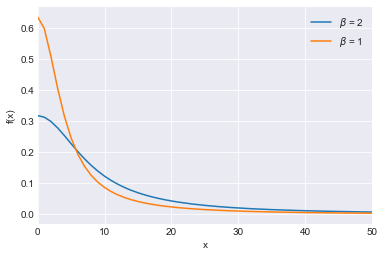

In [7]:
for b in [2, 1]:
    x = pm.HalfCauchy.dist(beta=b)
    plt.plot(np.exp(x.logp(np.linspace(0, 50, 200)).eval()),label=r'$\beta$ = {}'.format(b))
plt.xlim(0, 50)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

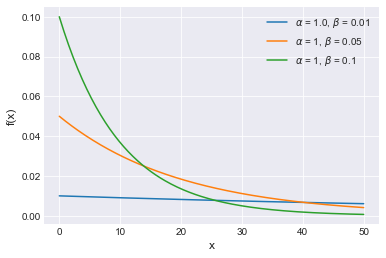

In [8]:

x = np.linspace(0, 50, 200)
alphas = [1., 1, 1]
betas = [0.01, 0.05, 0.1]
for a, b in zip(alphas, betas):
    pdf = st.gamma.pdf(x, a, scale=1.0/b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)


The model fitting function

In [9]:
def fit_model(y, X, prop_Xu, l_prior, eta_prior, sigma_prior, n=500, n_chains=2):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    l/eta/sigma_prior : the prior for the various hyperparameters
    
    X, y are dataframes. We'll use the column names. 
    """
    
    with pm.Model() as model:
        
        # labels
        X_labs = ['l_'+ x[:5] for x in X.columns]
        y_lab = y.name
        
        # Covert arrays
        X = X.values
        y = y.values
        
        # Length priors
        length_priors = []
        for i in range(len(X_labs)):
            length_priors.append(l_prior(X_labs[i]))

        # covariance prior
        eta = eta_prior('eta')
        
        # Covariance function
        cov = eta**2
        for i in range(len(X_labs)):
            cov = cov*pm.gp.cov.ExpQuad(X.shape[1], ls=length_priors[i], active_dims=[i])

        # Sparse Model
        # Shift the mean function up to mean of response values. 
        # This is to increase speed of convergence. Could equally 
        # have shifted response to zero. 
        gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")
        
        # Noise model
        sigma_n = sigma_prior('sigma_n')
        
        # Inducing variables
        num_Xu = int(X.shape[0]*prop_Xu)
        Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X)
       
        # Marginal likelihood
        y_ = gp.marginal_likelihood(y_lab, X=X, y=y,Xu=Xu, noise=sigma_n)
        
        # Sample
        trace = pm.sample(draws=n, chains=n_chains, cores=1)
        
    return model, trace, gp


Select the data we're going to use for this experiment

In [10]:
idx = (df['basis'] == 'ppo_tor') & (df['method'] == 'random') 
X = df.loc[idx, :].filter(regex='scaled$')
y = df.loc[idx, 'test_score']

do a check run: 

In [11]:
# model, trace, gp = fit_model(y=y, X=X, prop_Xu = 0.1, 
#                              l_prior=gamma(alpha=1, beta=1), 
#                              sigma_prior=hcauchy(beta=1), 
#                              eta_prior=hcauchy(beta=1))

# with model:
#     print(pm.stats.rhat(trace))

Now cycle through weakly informative and very informative. 

In [12]:
# priors are: ['weak', 'strong']
p_type = ['weak', 'strong', 'strongest']
l_priors = [(1, 0.01), (1, 0.05), (1, 0.1)]
e_priors = [3, 2, 1]
s_priors = [3, 2, 1]
num_priors = len(l_priors)

all_dfs = []
for i in range(num_priors): 
    model, trace, gp = fit_model(y=y, X=X, prop_Xu = 0.1, 
                             l_prior=gamma(alpha=l_priors[i][0], beta=l_priors[i][1]), 
                             sigma_prior=hcauchy(beta=s_priors[i]), 
                             eta_prior=hcauchy(beta=e_priors[i]), n=1000, n_chains=1)
    
    df_trace = pd.DataFrame({x : trace.get_values(x) for x in trace.varnames if x[-5:]!='log__'})
    df_trace['l_prior'] = '{}'.format(l_priors[i])
    df_trace['eta_prior'] = '{}'.format(e_priors[i])
    df_trace['sigma_prior'] = '{}'.format(s_priors[i])
    df_trace['prior_type'] = p_type[i]
    all_dfs.append(df_trace)
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/OneDr

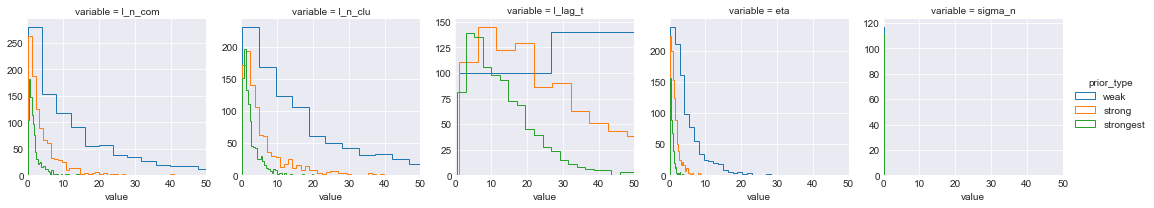

In [13]:
results = pd.concat(all_dfs)
results = results.melt(id_vars=['prior_type','l_prior', 'eta_prior', 'sigma_prior'])

g = sns.FacetGrid(data=results, col='variable', hue='prior_type', sharex=False, sharey=False)
g.map(sns.distplot, 'value', hist=True, kde=False, 
      hist_kws={"histtype": "step", "linewidth": 1,
                            "alpha": 1}).add_legend()
g.set(xlim=(0,50))

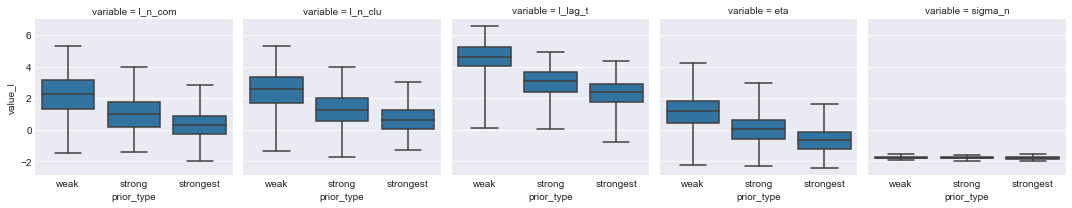

In [14]:
results.loc[:, 'value_l'] = np.log(results.loc[:, 'value'])

g = sns.FacetGrid(data=results, col='variable',col_wrap=5, sharey=True)
g.map(sns.boxplot,'prior_type','value_l', order=results['prior_type'].unique(), whis=5)

## Model 1: Three-way interaction only

We can conclude that the data does not have much influence, this is because the data is quite noisy and the model quite simplistic. For the lengthscale parameters there isn't much difference between the strong and strogest priors. We'll use the strong prior even though it is quite weak. 

In [113]:
model, trace, gp = fit_model(y=y, X=X, prop_Xu = 0.1, 
                         l_prior=gamma(alpha=l_priors[1][0], beta=l_priors[1][1]), 
                         sigma_prior=hcauchy(beta=s_priors[1]), 
                         eta_prior=hcauchy(beta=e_priors[1]), n=1000, n_chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_n, eta, l_lag_t, l_n_clu, l_n_com]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:26<00:00, 55.73it/s]
The number of effective samples is smaller than 25% for some parameters.


<xarray.Dataset>
Dimensions:  ()
Data variables:
    l_n_com  float64 1.004
    l_n_clu  float64 1.0
    l_lag_t  float64 0.9996
    eta      float64 1.002
    sigma_n  float64 1.001


/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matpl

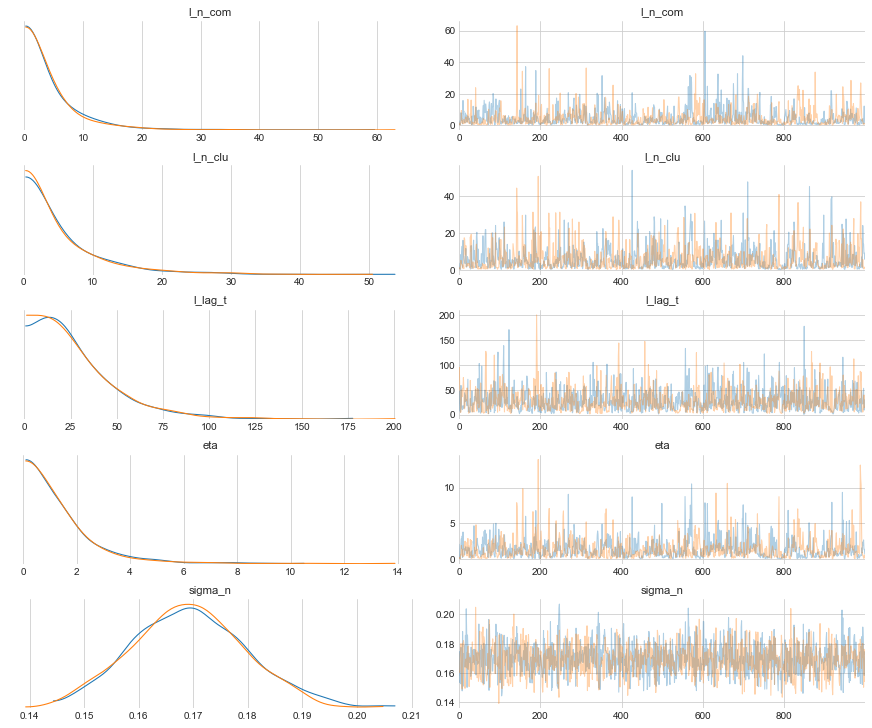

In [114]:
with model:
    print(pm.stats.rhat(trace))
    pm.traceplot(trace)

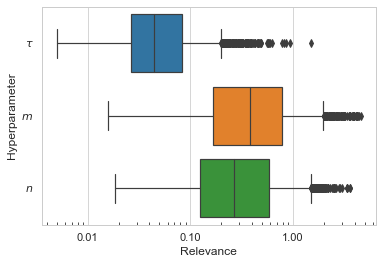

In [115]:
df_trace = pd.DataFrame({x : trace.get_values(x) for x in trace.varnames if x[-5:]!='log__'})
df_trace.columns = [r'$m$', r'$n$', r'$\tau$', r'$\eta$', r'$\sigma_n$']
df_trace.head()

len_labs = [ r'$\tau$', r'$m$', r'$n$']

relevance = pd.DataFrame(1/df_trace.loc[:, len_labs].values, columns=len_labs)
relevance_m = relevance.melt(var_name='Hyperparameter', value_name='Relevance')
with sns.plotting_context('paper', font_scale=1.25):
    sns.set_style('whitegrid')
    ax = sns.boxplot(data=relevance_m, x='Relevance', y='Hyperparameter', whis=2)
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(tk.StrMethodFormatter('{x:4.2f}'))
    ax.xaxis.set_minor_locator(tk.LogLocator(base=10.0, subs='auto', numdecs=4))
    ax.tick_params(which='minor', axis='x', bottom=True, direction='in')
    plt.savefig('figures/model_1_relevance_ppo.png', dpi=450 )

In [116]:
all_params = relevance.join(df_trace.loc[:, [r'$\eta$', r'$\sigma_n$']])

all_params.melt(var_name='Parameter').groupby('Parameter')['value'].\
aggregate(**{"Median": lambda x: "{:4.2f}".format(np.median(x)), 
             "95% CI": lambda x: "({0:4.2f}, {1:4.2f})".format(np.quantile(x, 0.025),np.quantile(x, 0.975))}).\
reset_index().\
to_csv('results/model_1_param_posterior.csv', index=False)
                                              

### Check other variance structure

In [117]:
def fit_model_2(y, X, prop_Xu, l_prior, eta_prior, sigma_prior, n=500, n_chains=2):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    l/eta/sigma_prior : the prior for the various hyperparameters
    
    X, y are dataframes. We'll use the column names. 
    """
    
    with pm.Model() as model:
        
        # labels
        X_labs = [x[:5] for x in X.columns]
        y_lab = y.name
        
        # Covert arrays
        X = X.values
        y = y.values
        
        ## Three way interaction
        # Length priors
        length_priors = []
        for i in range(len(X_labs)):
            length_priors.append(l_prior('l_'+X_labs[i]))
        # covariance prior
        eta = eta_prior('eta')               
        # Covariance function
        cov = eta**2
        for i in range(len(X_labs)):
            cov = cov*pm.gp.cov.ExpQuad(X.shape[1], ls=length_priors[i], active_dims=[i])
        
        ## Additive parts: 
        length_add_priors = []
        cov_priors = []
        for i in range(len(X_labs)):
            length_add_priors.append(l_prior('l_add_'+X_labs[i]))   
            cov_priors.append(eta_prior('eta_add_'+X_labs[i])) 

        cov_add = []
        for i in range(len(X_labs)):
            cov_add.append(cov_priors[i]**2*pm.gp.cov.ExpQuad(X.shape[1], ls=length_priors[i], active_dims=[i]))
        cov_add = np.sum(cov_add) 
        
        cov_total = cov_add + cov
            
        # Sparse Model
        # Shift the mean function up to mean of response values. 
        # This is to increase speed of convergence. Could equally 
        # have shifted response to zero. 
        gp = pm.gp.MarginalSparse(mean_func=pm.gp.mean.Constant(c=np.mean(y)), cov_func=cov_total, approx="FITC")
        
        # Noise model
        sigma_n = sigma_prior('sigma_n')
        
        # Inducing variables
        num_Xu = int(X.shape[0]*prop_Xu)
        Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X)
       
        # Marginal likelihood
        y_ = gp.marginal_likelihood(y_lab, X=X, y=y,Xu=Xu, noise=sigma_n)
        
        # Sample
        trace = pm.sample(draws=n, chains=n_chains, cores=1)
        
    return model, trace, gp

In [118]:
model2, trace2, gp2 = fit_model_2(y=y, X=X, prop_Xu = 0.1, 
                         l_prior=gamma(alpha=l_priors[1][0], beta=l_priors[1][1]), 
                         sigma_prior=hcauchy(beta=s_priors[1]), 
                         eta_prior=hcauchy(beta=e_priors[1]), n=1000, n_chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_n, eta_add_lag_t, l_add_lag_t, eta_add_n_clu, l_add_n_clu, eta_add_n_com, l_add_n_com, eta, l_lag_t, l_n_clu, l_n_com]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:25<00:00, 59.01it/s]


/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matpl

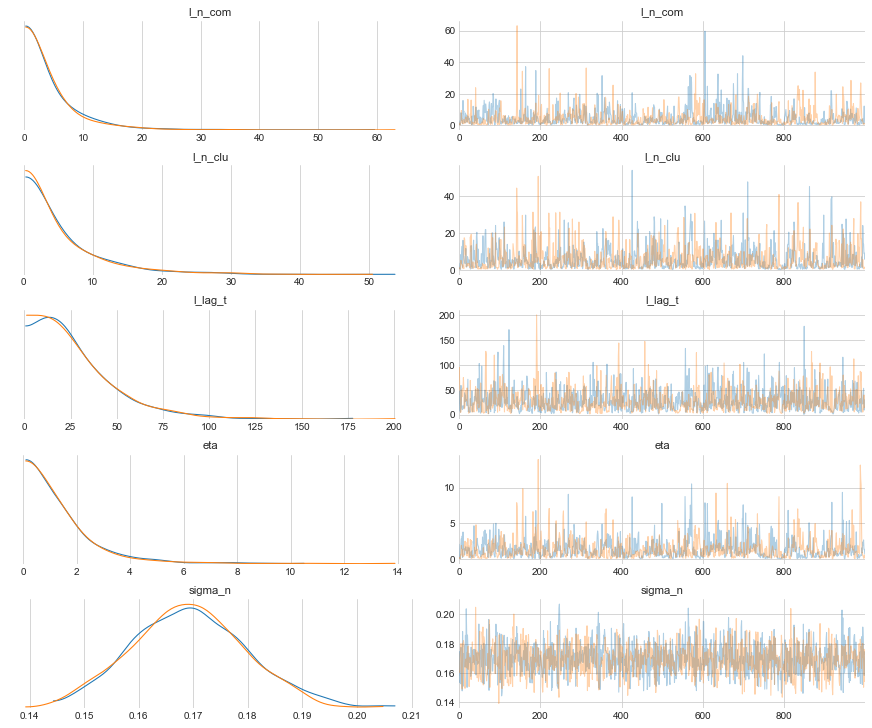

In [120]:
with model2:
    pm.traceplot(trace)

In [121]:
with model:
    f_pred = gp.conditional("f_pred", X.values)
with model2:
    f_pred2 = gp.conditional("f_pred", X.values)
    
    
# # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
# with model:
#     pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=2000)

In [122]:
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=100)

with model2:
    pred_samples2 = pm.sample_posterior_predictive(trace2, vars=[f_pred2], samples=100)

/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:10<00:00,  9.50it/s]


(1.1, 2.3)

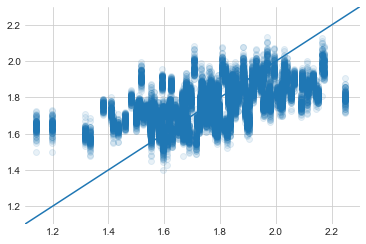

In [154]:
plt.scatter( np.tile(y.values, 100), pred_samples["f_pred"].flatten(), alpha=0.1)
plt.plot(np.array([1.1, 2.3]),np.array([1.1, 2.3]))
plt.xlim(1.1, 2.3)
plt.ylim(1.1, 2.3)


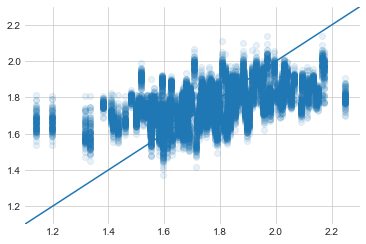

In [155]:
plt.scatter( np.tile(y.values, 100), pred_samples2["f_pred"].flatten(), alpha=0.1)
plt.xlim(1.1, 2.3)
plt.ylim(1.1, 2.3)
plt.plot(np.array([1.1, 2.3]),np.array([1.1, 2.3]))


### Check exponential kernel

In [158]:
def fit_model_3(y, X, prop_Xu, l_prior, eta_prior, sigma_prior, n=500, n_chains=2):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    l/eta/sigma_prior : the prior for the various hyperparameters
    
    X, y are dataframes. We'll use the column names. 
    """
    
    with pm.Model() as model:
        
        # labels
        X_labs = ['l_'+ x[:5] for x in X.columns]
        y_lab = y.name
        
        # Covert arrays
        X = X.values
        y = y.values
        
        # Length priors
        length_priors = []
        for i in range(len(X_labs)):
            length_priors.append(l_prior(X_labs[i]))

        # covariance prior
        eta = eta_prior('eta')
        
        # Covariance function
        cov = eta**2
        for i in range(len(X_labs)):
            cov = cov*pm.gp.cov.Exponential(X.shape[1], ls=length_priors[i], active_dims=[i])

        # Sparse Model
        # Shift the mean function up to mean of response values. 
        # This is to increase speed of convergence. Could equally 
        # have shifted response to zero. 
        gp = pm.gp.MarginalSparse(mean_func=pm.gp.mean.Constant(c=np.mean(y)), cov_func=cov, approx="FITC")
        
        # Noise model
        sigma_n = sigma_prior('sigma_n')
        
        # Inducing variables
        num_Xu = int(X.shape[0]*prop_Xu)
        Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X)
       
        # Marginal likelihood
        y_ = gp.marginal_likelihood(y_lab, X=X, y=y,Xu=Xu, noise=sigma_n)
        
        # Sample
        trace = pm.sample(draws=n, chains=n_chains, cores=1)
        
    return model, trace, gp


In [159]:
model3, trace3, gp3 = fit_model_3(y=y, X=X, prop_Xu = 0.1, 
                         l_prior=gamma(alpha=l_priors[1][0], beta=l_priors[1][1]), 
                         sigma_prior=hcauchy(beta=s_priors[1]), 
                         eta_prior=hcauchy(beta=e_priors[1]), n=1000, n_chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (2 c

/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matpl

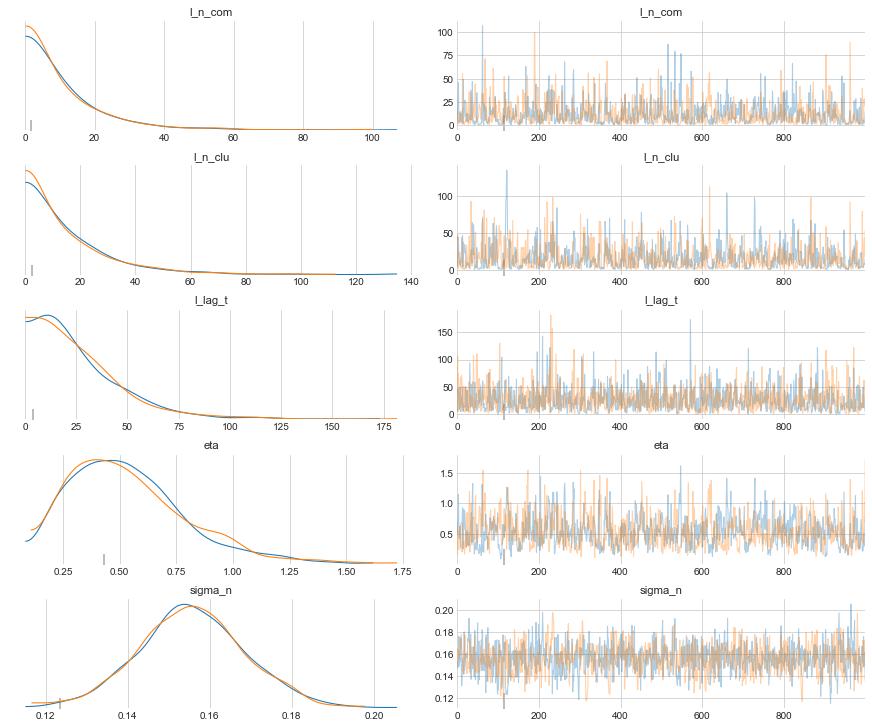

In [160]:
with model3: 
    pm.traceplot(trace3)

In [169]:
with model3:
#     f_pred3 = gp.conditional("f_pred3", X.values)
    pred_samples3 = pm.sample_posterior_predictive(trace3, vars=[f_pred3], samples=100)



100%|██████████| 100/100 [00:07<00:00, 14.02it/s]


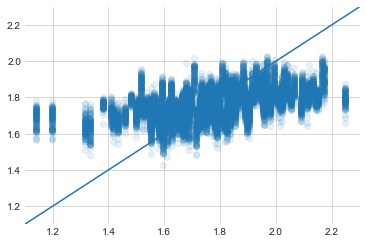

In [170]:

plt.scatter( np.tile(y.values, 100), pred_samples3["f_pred3"].flatten(), alpha=0.1)
plt.xlim(1.1, 2.3)
plt.ylim(1.1, 2.3)
plt.plot(np.array([1.1, 2.3]),np.array([1.1, 2.3]))

## Check additive structure

In [163]:
def fit_model_4(y, X, prop_Xu, l_prior, eta_prior, sigma_prior, n=500, n_chains=2):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    l/eta/sigma_prior : the prior for the various hyperparameters
    
    X, y are dataframes. We'll use the column names. 
    """
    
    with pm.Model() as model:
        
        # labels
        X_labs = [x[:5] for x in X.columns]
        y_lab = y.name
        
        # Covert arrays
        X = X.values
        y = y.values
        
        # Length priors
        cov_priors = []
        length_priors = []
        for i in range(len(X_labs)):
            length_priors.append(l_prior('l_'+X_labs[i]))
            cov_priors.append(eta_prior('eta{}'.format(i+1)))
            
        cov_total = []
        for i in range(len(X_labs)):
            cov_total.append(cov_priors[i]**2*pm.gp.cov.ExpQuad(X.shape[1], ls=length_priors[i], active_dims=[i]))
        
        cov_total = np.sum(cov_total)            
        # Sparse Model
        # Shift the mean function up to mean of response values. 
        # This is to increase speed of convergence. Could equally 
        # have shifted response to zero. 
        gp = pm.gp.MarginalSparse(mean_func=pm.gp.mean.Constant(c=np.mean(y)), cov_func=cov_total, approx="FITC")
        
        # Noise model
        sigma_n = sigma_prior('sigma_n')
        
        # Inducing variables
        num_Xu = int(X.shape[0]*prop_Xu)
        Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X)
       
        # Marginal likelihood
        y_ = gp.marginal_likelihood(y_lab, X=X, y=y,Xu=Xu, noise=sigma_n)
        
        # Sample
        trace = pm.sample(draws=n, chains=n_chains, cores=1)
        
    return model, trace, gp

In [164]:
model4, trace4, gp4 = fit_model_4(y=y, X=X, prop_Xu = 0.1, 
                         l_prior=gamma(alpha=l_priors[1][0], beta=l_priors[1][1]), 
                         sigma_prior=hcauchy(beta=s_priors[1]), 
                         eta_prior=hcauchy(beta=e_priors[1]), n=1000, n_chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (2 c

In [171]:
with model4:
    f_pred4 = gp.conditional("f_pred", X.values)
    pred_samples4 = pm.sample_posterior_predictive(trace4, vars=[f_pred4], samples=100)




100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


KeyError: 'f_pred'

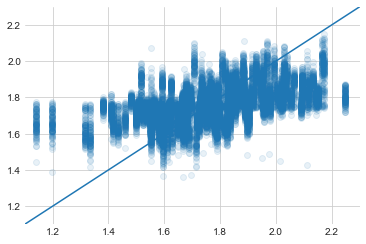

In [172]:
plt.scatter( np.tile(y.values, 100), pred_samples4["f_pred"].flatten(), alpha=0.1)
plt.xlim(1.1, 2.3)
plt.ylim(1.1, 2.3)
plt.plot(np.array([1.1, 2.3]),np.array([1.1, 2.3]))

1.7636631578321882